# Prompt to Extract Key-values into JSON from CBC Reports (Image) using advanced mode

Below it's an example of using OpenParser to extract key-values from a medical CBC report into JSON format. (Note: the model is still in beta and is NOT robust enough to generate the same output. Please bear with it!)

### 1. Load the libraries

If you have install `open_parser`, uncomment the below line.

In [21]:
# !pip3 install python-dotenv
# !pip3 install --upgrade open_parser
# !pip3 install pandas
# !pip3 install jinja2

In [22]:
import os
import pandas as pd

from dotenv import load_dotenv
from open_parser import OpenParser
from IPython.display import Image
from medical_cbc_report_data.expected_result import expected_result


### 2. Set up your OpenParser API key

To set up your `CAMBIO_API_KEY` API key, you will:

1. create a `.env` file in your root folder;
2. add the following one line to your `.env file:
    ```
    CAMBIO_API_KEY=17b************************
    ```

Then run the below line to load your API key.

In [23]:
load_dotenv(override=True)
example_apikey = os.getenv("CAMBIO_API_KEY")

### 3. Load sample data and Run OpenParser

OpenParser supports both image and PDF.  First let's load a sample data to test OpenParser's capabilities.

In [24]:
report_folder = './medical_cbc_report_data/'
report_files = [
    'CBC_ReportSample_1.png',
    'CBC_ReportSample_12.jpeg',
    'CBC_ReportSample_14.jpeg',
    'CBC_ReportSample_20.jpeg',
]

Let's take a quick look at the raw images.

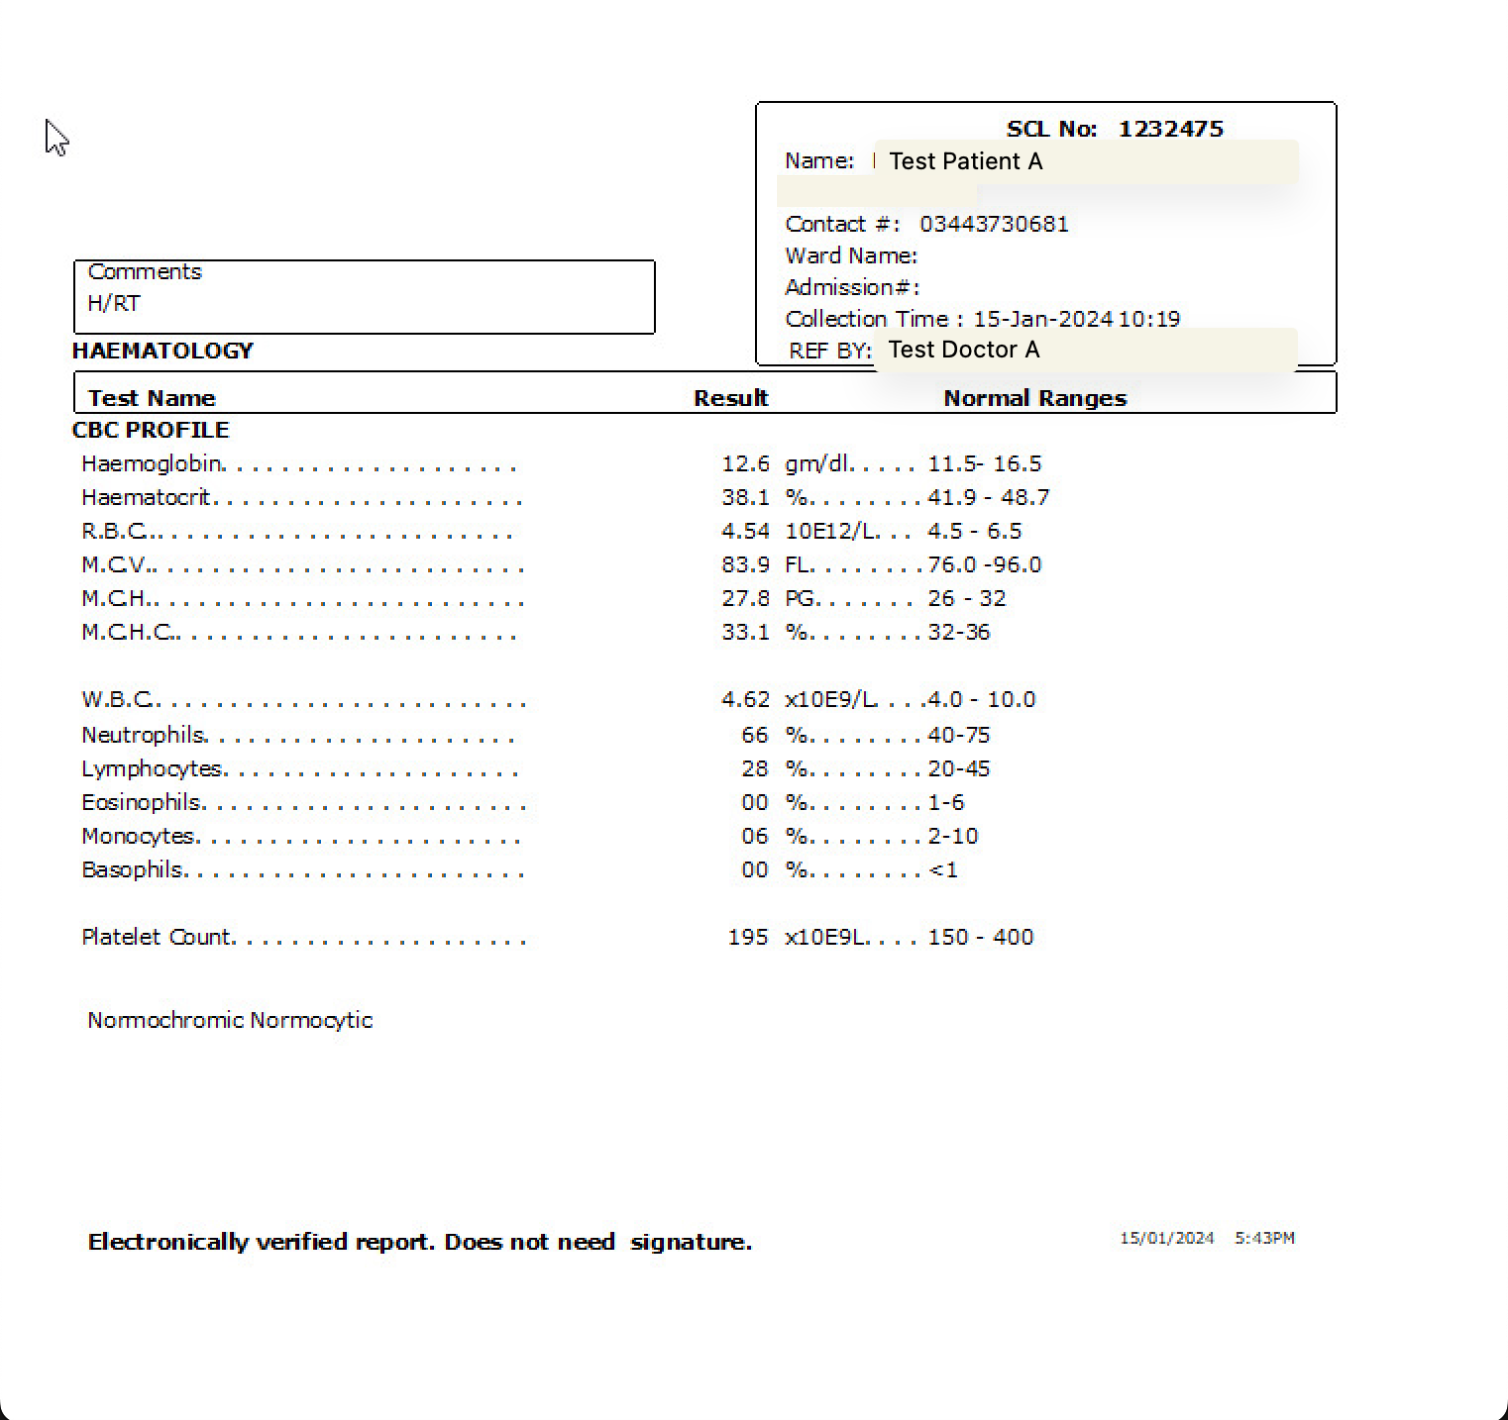

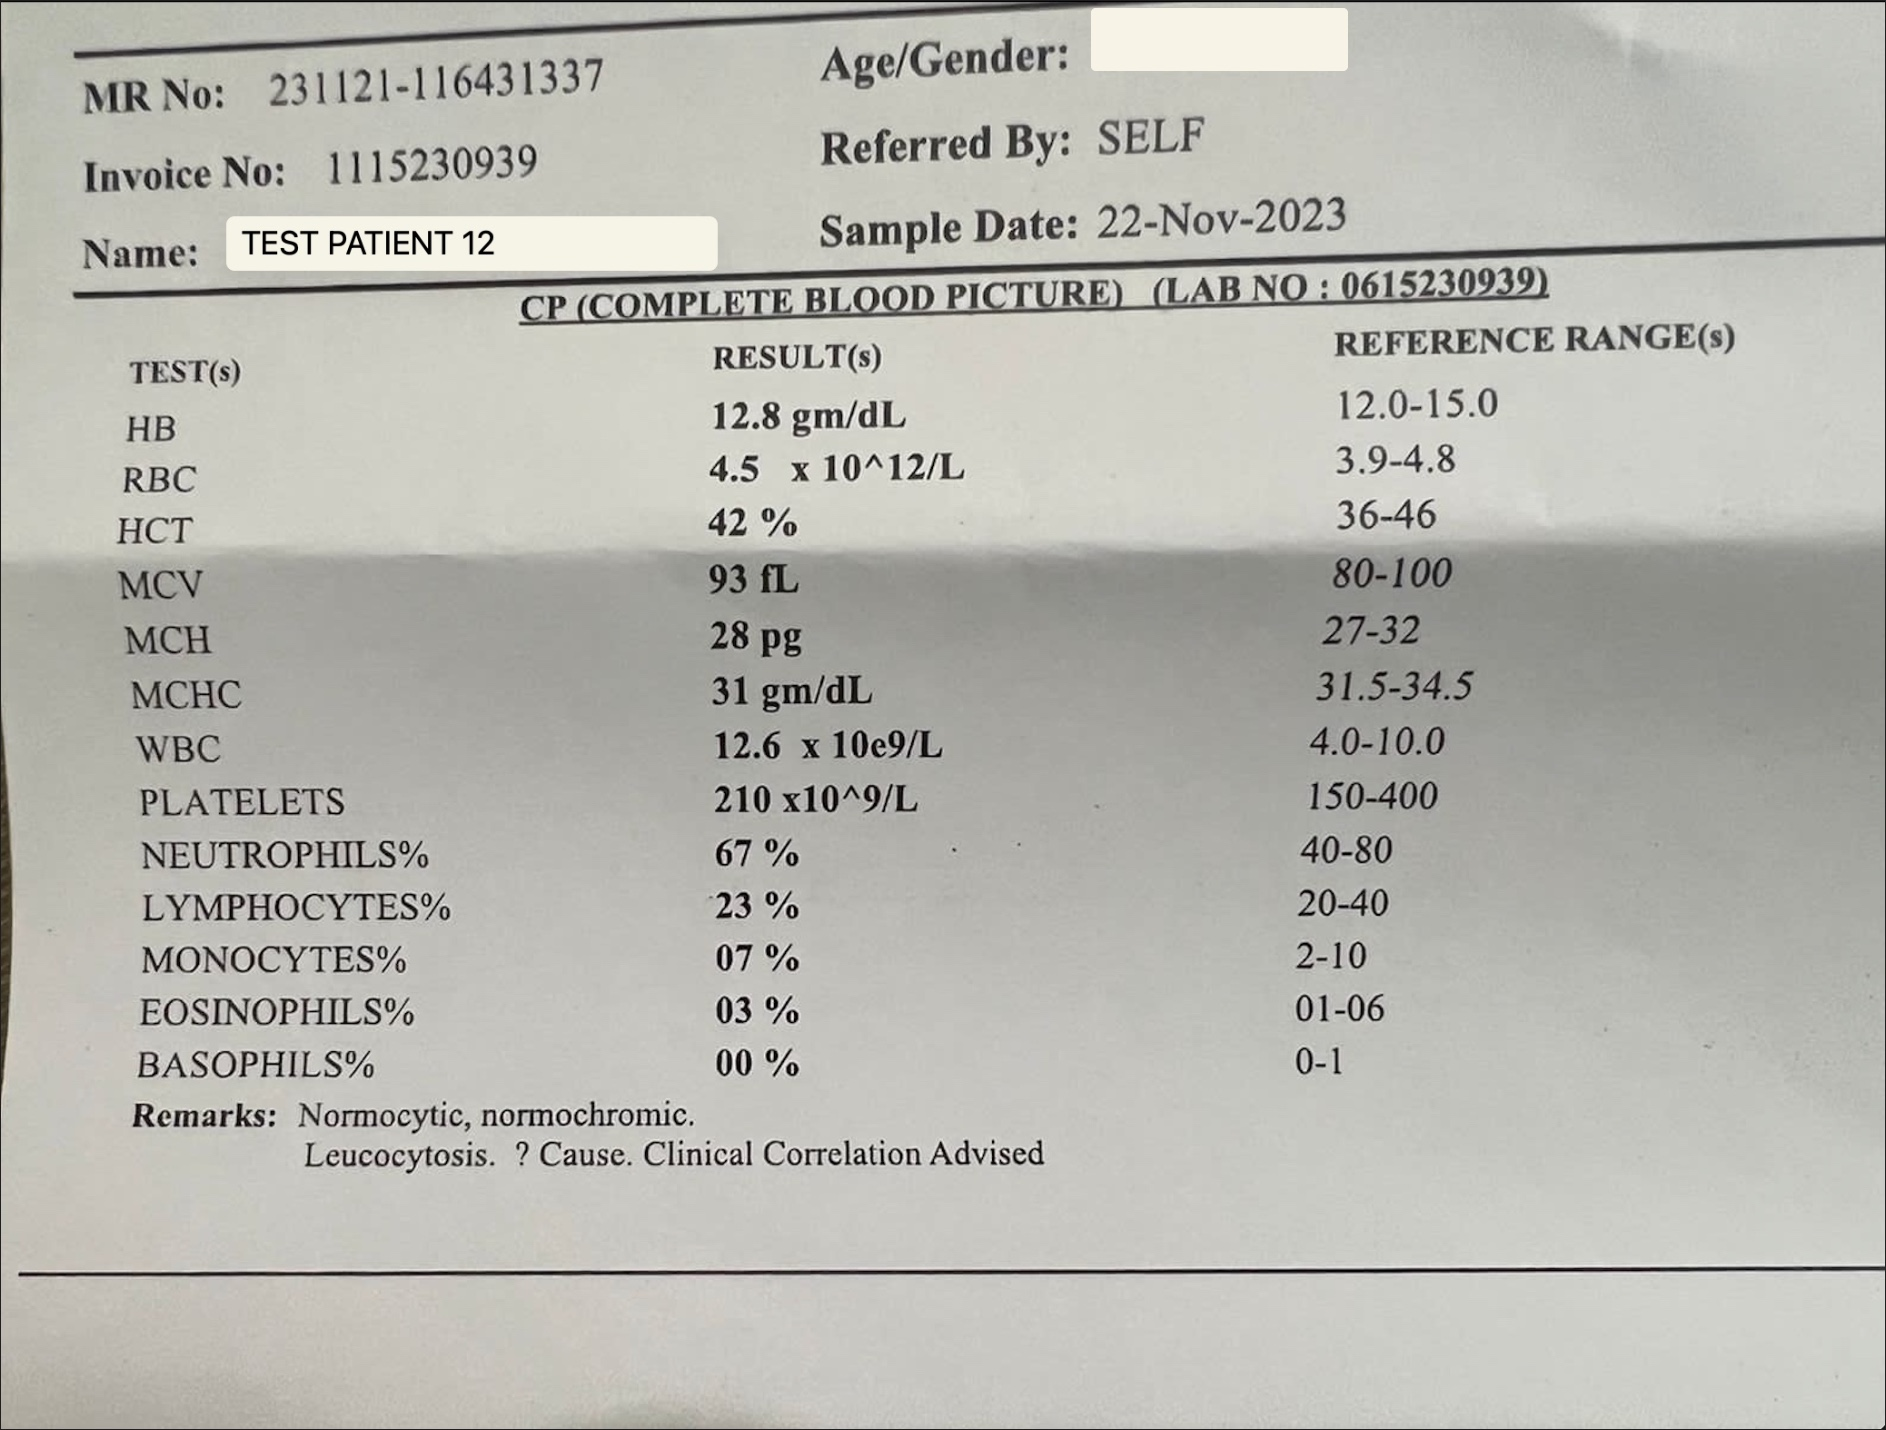

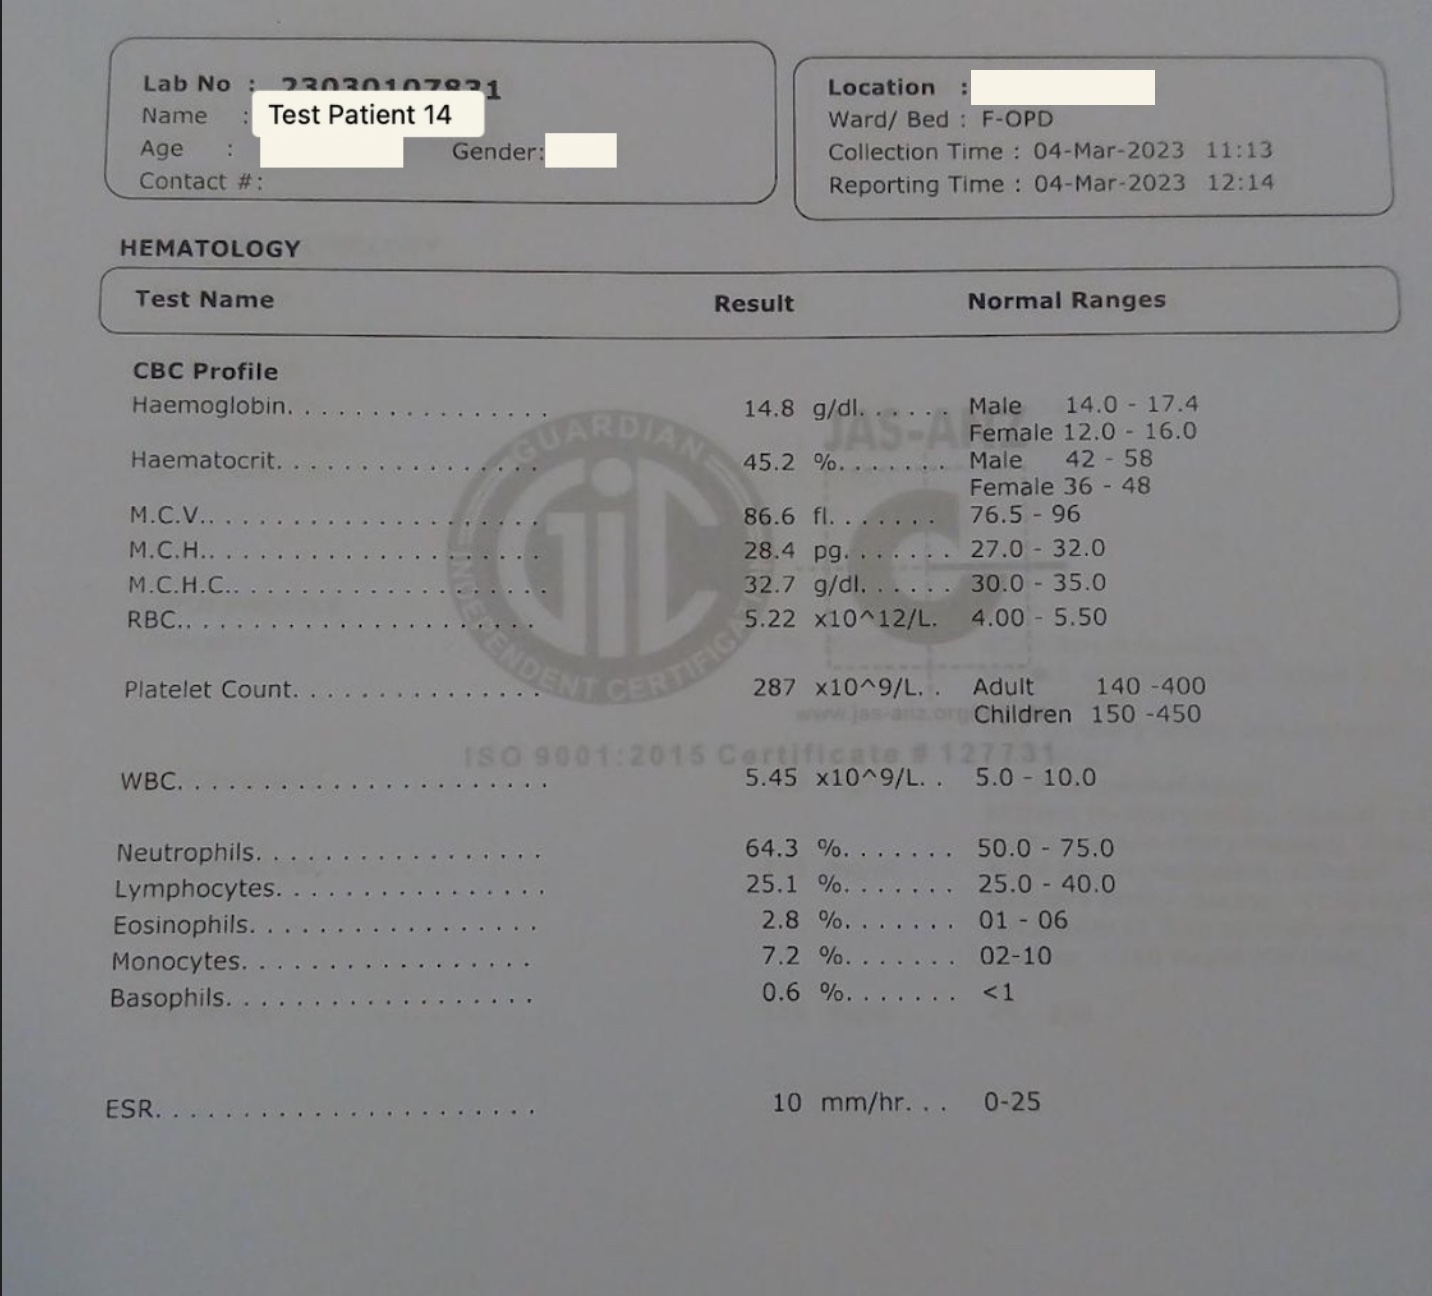

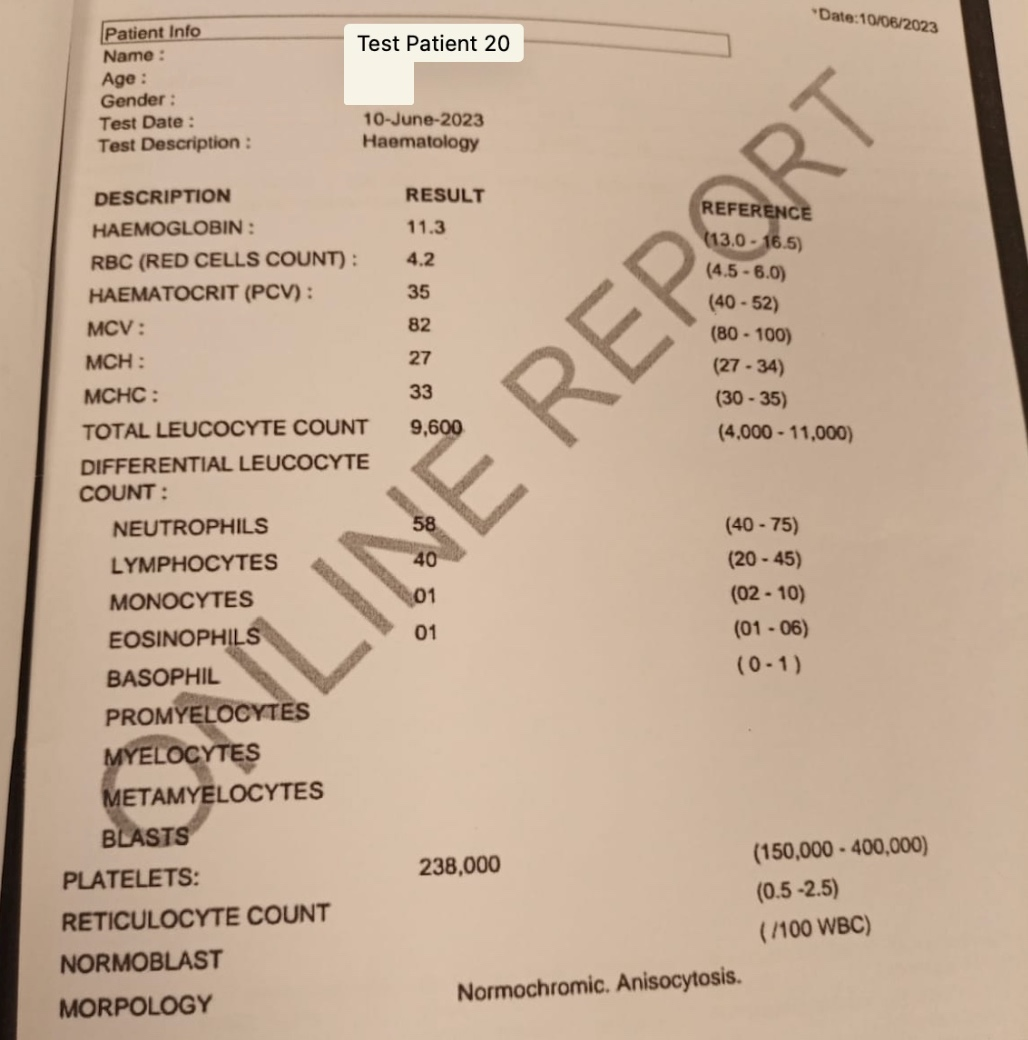

In [36]:
image_paths = [report_folder + f for f in report_files]
images = []


for image_path in image_paths:
    images.append(Image(filename=image_path))

display(*images)

As you can see, extracting the keys and values from the image is not straightforward due to variation in terms and formatting. For example, for Red Cells count, you have many different keys: `RBC`, `R.B.C.`, and `RBC (Red Cells Count)`.

Next, we'll set our `input_keys`, which are the keys that we want to extract from the report. These are commonly used CBC report metrics, so we'd like to extract this data across the different CBC reports.

In [5]:
input_keys = ['NAME', 'HAEMOGLOBIN', 'RBC (RED CELLS COUNT)', 'HAEMATOCRIT(PCV)','MCV','MCH','MCHC','TOTAL LEUCOCYTE COUNT','DIFFERENTIAL LEUCOCYTE COUNT', 'NEUTROPHILS','LYMPHOCYTES','MONOCYTES', 'EOSINOPHILS', 'BASOPHIL', 'PROMYELOCYTES', 'MYELOCYTES', 'METAMYELOCYTES', 'BLASTS', 'PLATELETS', 'RETICULOCYTE COUNT']

Finally, we set up our prompt and run OpenParser on the data.

In [7]:
prompt = f"""Return table in a JSON format with all of the following keys and their corresponding values:
{input_keys}

If a key and/or value is not found in the text, please still include the key with a value of `NA`.

Return all values as strings and always use `.` to separate decimals.
"""
op = OpenParser(example_apikey)
qa_results = []
for file in report_files:
    qa_result = op.parse(report_folder + file, prompt, mode="advanced")
    qa_results.append(qa_result)

Upload response: 204
Extraction success.
Upload response: 204
Extraction success.
Upload response: 204
Extraction success.
Upload response: 204
Extraction success.


Here is the raw output.

In [8]:
qa_results

[{'result': [{'NAME': 'Test Patient A',
    'HAEMOGLOBIN': '12.6',
    'RBC (RED CELLS COUNT)': '4.54',
    'HAEMATOCRIT(PCV)': '38.1',
    'MCV': '83.9',
    'MCH': '27.8',
    'MCHC': '33.1',
    'TOTAL LEUCOCYTE COUNT': '4.62',
    'NEUTROPHILS': '66',
    'LYMPHOCYTES': '28',
    'MONOCYTES': '06',
    'EOSINOPHILS': '00',
    'BASOPHIL': '00',
    'PROMYELOCYTES': 'NA',
    'MYELOCYTES': 'NA',
    'METAMYELOCYTES': 'NA',
    'BLASTS': 'NA',
    'PLATELETS': '195',
    'RETICULOCYTE COUNT': 'NA'}]},
 {'result': [{'NAME': 'TEST PATIENT 12',
    'HAEMOGLOBIN': '12.8',
    'RBC (RED CELLS COUNT)': '4.5',
    'HAEMATOCRIT(PCV)': '42.0',
    'MCV': '93.0',
    'MCH': '28.0',
    'MCHC': '31.0',
    'TOTAL LEUCOCYTE COUNT': '12.6',
    'NEUTROPHILS': '67.0',
    'LYMPHOCYTES': '23.0',
    'MONOCYTES': '7.0',
    'EOSINOPHILS': '3.0',
    'BASOPHIL': '0.0',
    'PLATELETS': '210.0',
    'RETICULOCYTE COUNT': 'NA'}]},
 {'result': [{'NAME': 'Test Patient 14',
    'HAEMOGLOBIN': '14.8',
    

## Output Analysis
Now, we will analyze the output and compare it with the expected result. We'll take not of any missing keys, any additional keys added by OpenParser, and any incorrect values.

In [9]:
values_list = []

def compare_vals(str1, str2):
    try:
        num1 = float(str1)
        num2 = float(str2)
        return num1 == num2
    except ValueError:
        return str1 == str2

for idx, qa_result in enumerate(qa_results):
    print('---------------------------------------------------')
    print(f"REPORT {idx+1}\n")
    data = qa_result['result']
    keys = [list(item.keys()) for item in data][0]
    values = [list(item.values()) for item in data][0]

    this_expected_result = expected_result[idx]
    missing_keys = []
    incorrect_keys = []
    expected_keys = list(this_expected_result.keys())

    for key_idx, key in enumerate(expected_keys):
        if key_idx < 0 or key_idx >= len(keys) or key != keys[key_idx]:
            print(f"Key {key} not found in report {idx+1}")
            missing_keys.append(key)
            keys.insert(key_idx, key)
            values.insert(key_idx, 'Missing')
        elif not compare_vals(this_expected_result[key], values[keys.index(key)]):
            print(f"Incorrect {key}. Expected: {this_expected_result[key]}, Found: {values[keys.index(key)]}")
            incorrect_keys.append((key, this_expected_result[key], values[keys.index(key)]))
            values[keys.index(key)] = f'{values[keys.index(key)]} * ({this_expected_result[key]})'

    different_keys = {'missing_keys': missing_keys, 'additional_keys': [], 'incorrect_keys': incorrect_keys}

    # Check for differences in keys
    for key in keys:
        if key not in input_keys:
            different_keys['additional_keys'].append(key)
    print(f"Summary: {different_keys}")

    # Create a DataFrame
    values_list.append(values)


---------------------------------------------------
REPORT 1

Key DIFFERENTIAL LEUCOCYTE COUNT not found in report 1
Summary: {'missing_keys': ['DIFFERENTIAL LEUCOCYTE COUNT'], 'additional_keys': [], 'incorrect_keys': []}
---------------------------------------------------
REPORT 2

Key DIFFERENTIAL LEUCOCYTE COUNT not found in report 2
Key PROMYELOCYTES not found in report 2
Key MYELOCYTES not found in report 2
Key METAMYELOCYTES not found in report 2
Key BLASTS not found in report 2
Summary: {'missing_keys': ['DIFFERENTIAL LEUCOCYTE COUNT', 'PROMYELOCYTES', 'MYELOCYTES', 'METAMYELOCYTES', 'BLASTS'], 'additional_keys': [], 'incorrect_keys': []}
---------------------------------------------------
REPORT 3

Summary: {'missing_keys': [], 'additional_keys': [], 'incorrect_keys': []}
---------------------------------------------------
REPORT 4

Summary: {'missing_keys': [], 'additional_keys': [], 'incorrect_keys': []}


Last, we print out the table with all the values extracted from the report. If a value is missing, it's highlighted yellow. If it's an incorrect value, it's highlighted red with the expected value in parentheses.

In [10]:
df = pd.DataFrame({
    report_files[0]: values_list[0],
    report_files[1]: values_list[1],
    report_files[2]: values_list[2],
    report_files[3]: values_list[3],
}, index=input_keys)

def highlight_incorrect_keys(val):
    if val == 'Missing':
        return 'background-color: yellow; color: black'
    elif '*' in val:
            return 'background-color: red'
    return ''

# Apply the style to the DataFrame
styled_df = df.style.applymap(highlight_incorrect_keys)

# Display the styled DataFrame
styled_df


/var/folders/39/ddf_qmj154l0k4jvqgngmxjm0000gn/T/ipykernel_59224/2497480378.py:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(highlight_incorrect_keys)


,CBC_ReportSample_1.png,CBC_ReportSample_12.jpeg,CBC_ReportSample_14.jpeg,CBC_ReportSample_20.jpeg
NAME,Test Patient A,TEST PATIENT 12,Test Patient 14,Test Patient 20
HAEMOGLOBIN,12.6,12.8,14.8,11.3
RBC (RED CELLS COUNT),4.54,4.5,5.22,4.2
HAEMATOCRIT(PCV),38.1,42.0,45.2,35
MCV,83.9,93.0,86.6,82
MCH,27.8,28.0,28.4,27
MCHC,33.1,31.0,32.7,33
TOTAL LEUCOCYTE COUNT,4.62,12.6,5.45,"9,600"
DIFFERENTIAL LEUCOCYTE COUNT,Missing,Missing,NA,NA
NEUTROPHILS,66,67.0,64.3,58


## End of the notebook

Check more [case studies](https://www.cambioml.com/blog) of CambioML!

<a href="https://www.cambioml.com/" title="Title">
    <img src="./sample_data/cambioml_logo_large.png" style="height: 100px; display: block; margin-left: auto; margin-right: auto;"/>
</a>